# Model Evaluation and Interpretation

In [1]:
from fastai.text import *
from fastai.lm_rnn import *
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import html

TWEETSLM_PATH=Path('./LM_tweets_best')
CLAS_PATH=Path('./tweets_class')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

# Helper Functions

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Results

F1(macro) =  0.7026971368599696
Accuracy  =  0.717948717948718


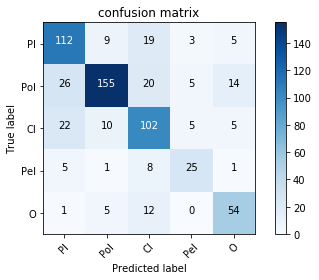

In [4]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
tst_lbls -= tst_lbls.min()
c=int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PI', 'PoI', 'CI', 'PeI', 'O'], title='confusion matrix')
plt.show()

# EDA

In [20]:
tokens = [" ".join([itos[id] for id in tweet]) for tweet in tst_sent]
df = pd.DataFrame({'tokens':tokens, 
                   'actual': tst_lbls_sampled , 
                   'prediction': predictions})


df['actual'] = df['actual'].replace([0, 1, 2, 3, 4], ['PI', 'PoI', 'CI', 'PeI', 'O'])
df['prediction'] = df['prediction'].replace([0, 1, 2, 3, 4], ['PI', 'PoI', 'CI', 'PeI', 'O'])


In [30]:
wrong_preds = df.loc[df['actual']!=df['prediction']]['tokens']
print(wrong_preds.shape)
print_full(wrong_preds)

(176,)
0      \n xbos rt @csgranada : @csgranada va a ayudar con todas sus _unk_ a @albert_rivera para ser el presidente que españa merece hash_tag # _unk_ hyp_link                                                                                                                                                                                                                       
2      \n xbos rt _unk_ : .@ t_up upyd cree que el t_up psoe acabará _unk_ un gobierno de rajoy y luego hará un " _unk_ " para _unk_ hash_tag # t_up 20d hyp_link                                                                                                                                                                                                                   
8      \n xbos _unk_ _unk_ la _unk_ y por favor urgente _unk_ cambios en _unk_ ! ! es _unk_ de _unk_ dar protección a sus ciudadanos !                                                                                                                 

In [31]:
right_preds = df.loc[df['actual']==df['prediction']]['tokens']
print(right_preds.shape)
print_full(right_preds)

(448,)
1      \n xbos _unk_ _unk_ _unk_ _unk_ es vota a pablo iglesias que apoya a bildu y los _unk_ de eta                                                                                                                                                                                                                                                                   
3      \n xbos rt _unk_ : el hash_tag # t_up 20d hemos de echar a los que han querido _unk_ en poder hash_tag # _unk_ hash_tag # _unk_ hyp_link                                                                                                                                                                                                                        
4      \n xbos _unk_ _unk_ _unk_ no te _unk_ tanto pq el que slang_string va a votar al pp vais a ser vosotros . nos vemos por aquí cuando t_up _unk_ ok ?                                                                                                                       

# EDA continued

In [28]:
PI_df =df.loc[df['actual']=='PI']
PI_df['prediction'].value_counts()

PI     112
CI      19
PoI      9
O        5
PeI      3
Name: prediction, dtype: int64